In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from matplotlib import cm

In [2]:
df = pd.read_excel("../data/premiums_rest.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [3]:
df.shape

(29904, 13)

### Data Cleaning: Converting titles into consistent names with lower case and underscore between 2 words

In [4]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


### Handling NA Values

In [5]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Checking for duplicate values. If new file contains duplicates, the code can adjust for that

In [7]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [8]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


### Checking for and treating negative number of dependents

In [9]:
df[df.number_of_dependants<0].shape

(50, 13)

In [10]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-1, -3])

In [11]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

### Checking for outliers in other numeric columns

In [12]:
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

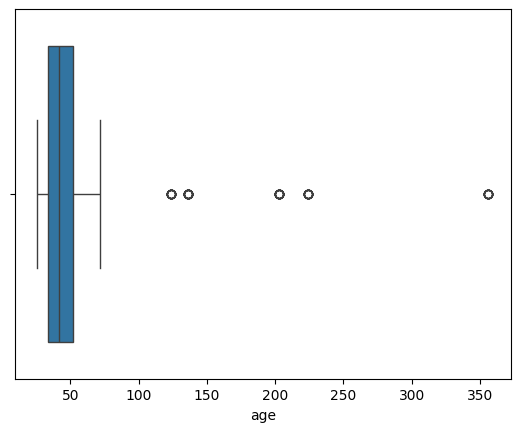

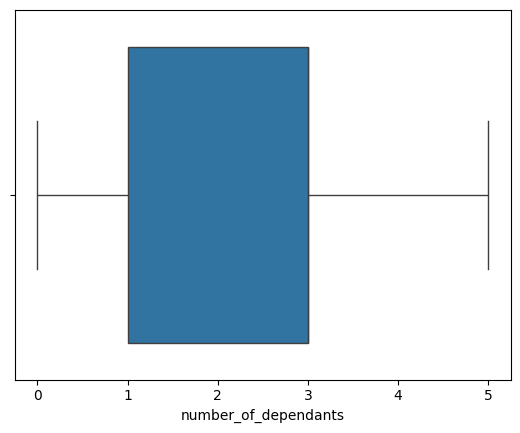

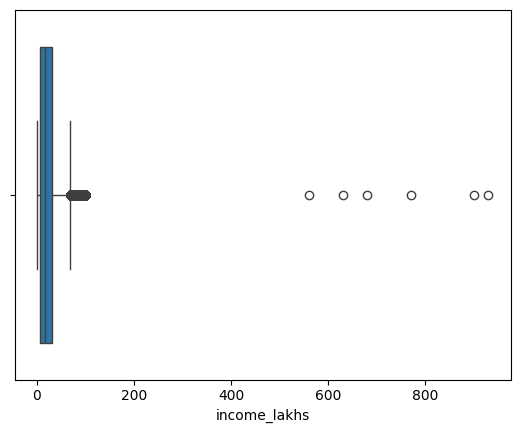

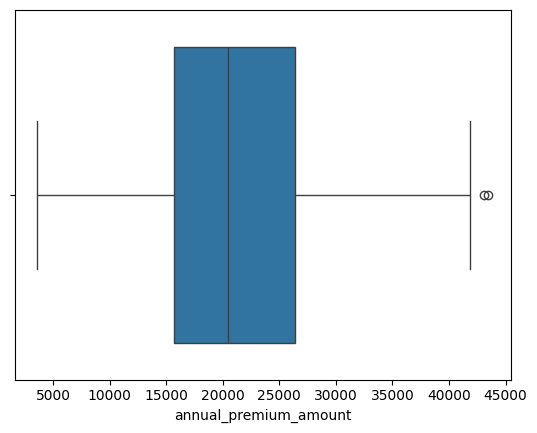

In [13]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

In [14]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [15]:
#Dropping all rows with age > 100
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

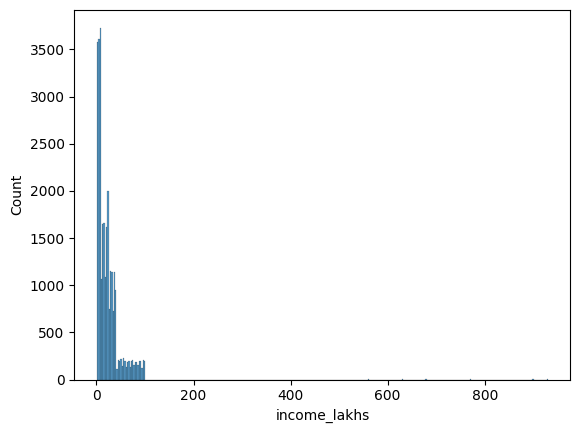

In [16]:
sns.histplot(df1.income_lakhs)

In [17]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [18]:
get_iqr_bounds(df.income_lakhs)

(-30.5, 69.5)

In [19]:
#Upper bound is 67 Lakhs per annum, which is very reasonable in India. Hence, using a better upper limit using top 99% income
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

np.float64(100.0)

In [20]:
df1[df1.income_lakhs>quantile_thresold].shape

(6, 13)

#### Only 10 people in our dataset have income greater than 100 lakhs per annum, so we can safely drop these as outliers

In [21]:
df2 = df1[df1.income_lakhs<=quantile_thresold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


### EDA 

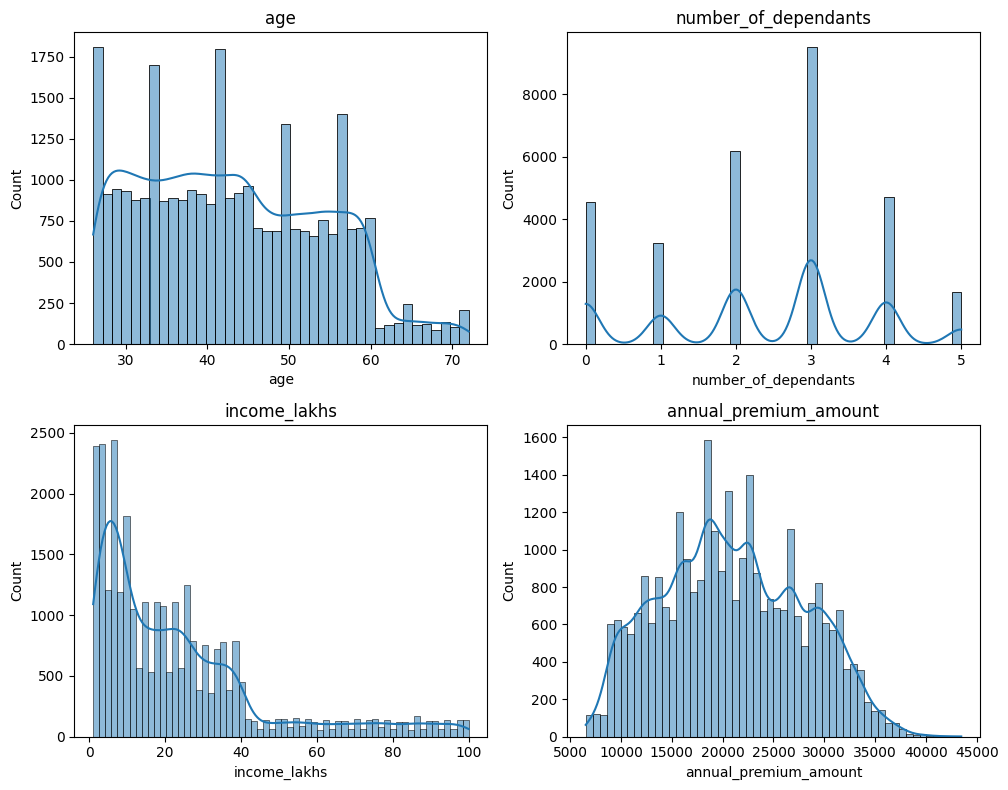

In [22]:
# Distributions for dataset after removing outliers
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axs = axs.flatten()

for ax, col in zip(axs, numeric_columns):
    sns.histplot(df2[col], kde=True, ax=ax)
    ax.set_title(col)
    
plt.tight_layout()
plt.show()

### Bi-Variate Analysis between independent numeric variables and dependent numeric variable

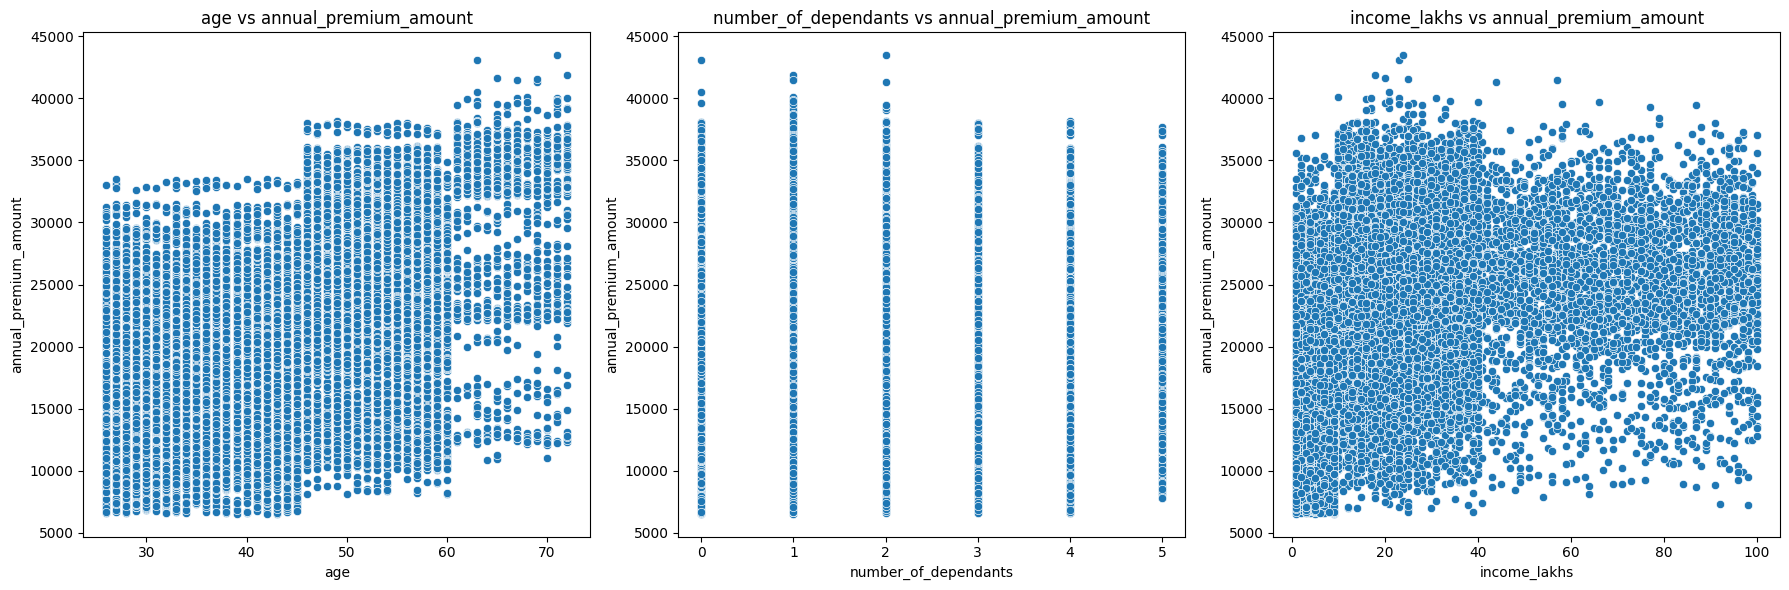

In [23]:
numeric_features = ['age', 'number_of_dependants', 'income_lakhs']

fig, axes = plt.subplots(1, len(numeric_features), figsize = (18,6))

for ax, col in zip(axes, numeric_features):
    sns.scatterplot(x=df2[col], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f"{col} vs annual_premium_amount")
    ax.set_xlabel(col)
    ax.set_ylabel("annual_premium_amount")

plt.tight_layout()
plt.show()


### Moving on to the categorical columns

In [24]:
df2.dtypes

age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
dtype: object

In [25]:
categorical_cols = df2.select_dtypes('object').columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [26]:
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


### Replacing duplicate "No-smoking" values with one.

In [27]:
df2['smoking_status'] = df2['smoking_status'].replace({
    "Smoking=0": "No Smoking",
     "Does Not Smoke": "No Smoking",
     "Not Smoking": "No Smoking" 
})

df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [28]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.549125
Female    0.450875
Name: proportion, dtype: float64

In [29]:
pct_count.values

array([0.54912481, 0.45087519])

### Percentage distribution of policy holders per categorical variable

C:\Users\kusha\AppData\Local\Temp\ipykernel_24176\2094765434.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


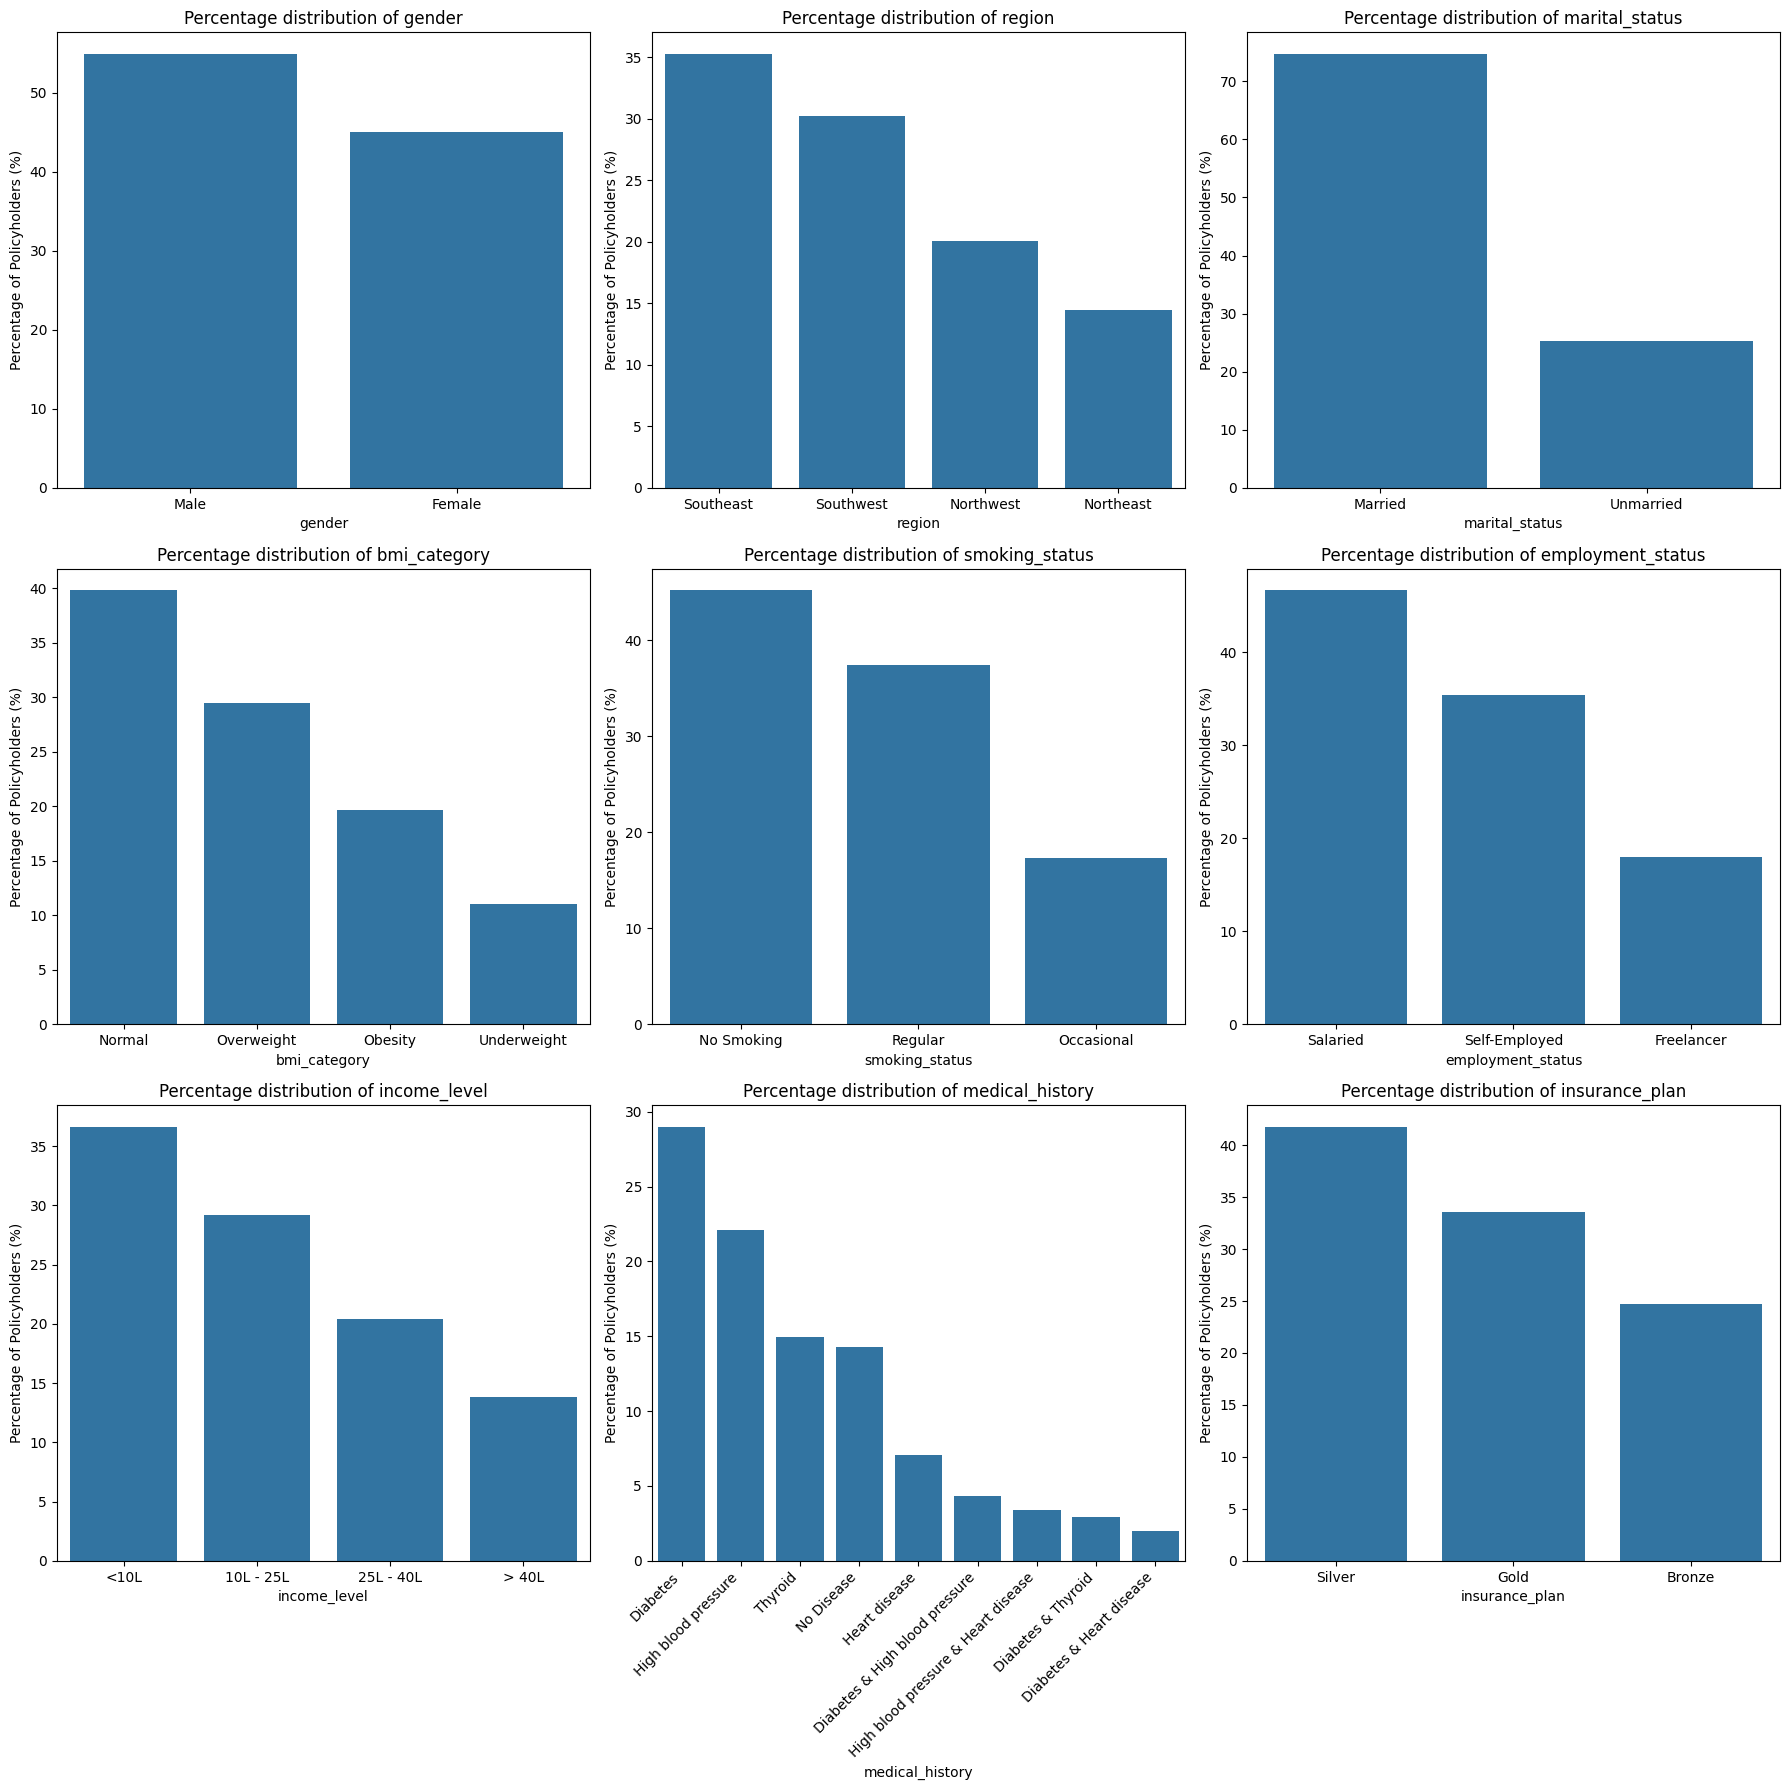

In [30]:
fig, axes = plt.subplots(3,3, figsize = (18,18))
axes = axes.flatten()

for ax,col in zip(axes,categorical_cols):
    category_counts = df2[col].value_counts(normalize=True) * 100

    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f"Percentage distribution of {col}")
    ax.set_ylabel("Percentage of Policyholders (%)")
    ax.set_xlabel(col)

    if col == 'medical_history':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Bivariate analysis for categorical columns: Income Level and type of Insurance Plan

In [31]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


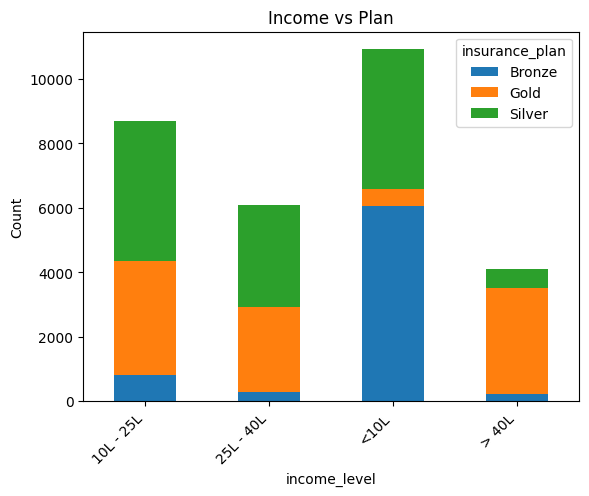

In [32]:
crosstab.plot(kind="bar", stacked = True)
plt.title("Income vs Plan")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

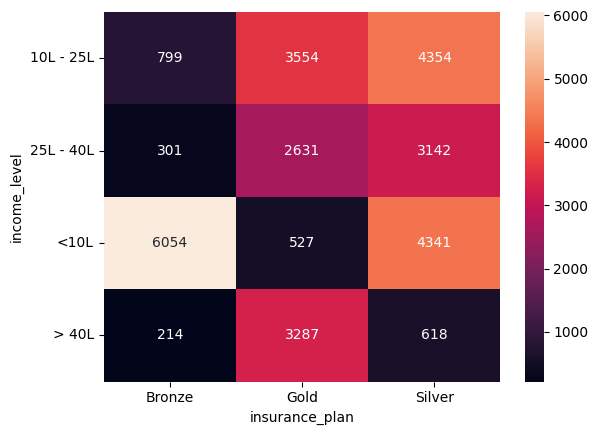

In [33]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.yticks(rotation=0)
plt.show()

### Feature Engineering

#### Ordinal variable columns

In [34]:
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [35]:
#Upon talking with the client, we have decided to assign certain risk scores for diseases. 
#If a person has multiple diseases, the total risk score would be the sum of individual risk scores.

risk_scores = {
    "diabetes" : 6,
    "high blood pressure" : 6,
    "thyroid" : 5,
    "heart disease" : 8,
    "no disease": 0,
    "none": 0
}

In [36]:
#Creating new columns for multiple diseases

df2[['disease_1','disease_2']] = df2['medical_history'].str.split("&", expand=True).apply(lambda x:x.str.lower().str.strip())
df2.head(10)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,None
5,33,Male,Southeast,Married,3,Normal,Regular,Self-Employed,<10L,4,Diabetes & High blood pressure,Silver,20653,diabetes,high blood pressure
6,43,Male,Northeast,Married,3,Overweight,Regular,Salaried,> 40L,46,Thyroid,Gold,26926,thyroid,None
7,59,Female,Southeast,Unmarried,0,Overweight,No Smoking,Freelancer,10L - 25L,21,No Disease,Gold,26101,no disease,None
8,46,Female,Southeast,Married,4,Normal,Occasional,Self-Employed,10L - 25L,21,Thyroid,Gold,27176,thyroid,None
9,68,Female,Southwest,Married,1,Normal,No Smoking,Self-Employed,<10L,1,Diabetes,Bronze,12596,diabetes,None


In [37]:
df2['disease_1'] = df2['disease_1'].fillna('none')
df2['disease_2'] = df2['disease_2'].fillna('none')
df2['total_risk_score'] = 0

for disease in ['disease_1','disease_2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score']-min_score)/(max_score-min_score)
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,normalized_risk_score
29740,30,Female,Southeast,Unmarried,1,Normal,No Smoking,Salaried,25L - 40L,27,High blood pressure,Silver,15101,high blood pressure,none,6,0.428571
21543,49,Female,Northeast,Married,4,Normal,Regular,Self-Employed,25L - 40L,29,High blood pressure & Heart disease,Gold,33388,high blood pressure,heart disease,14,1.000000
14413,27,Female,Northwest,Married,3,Obesity,No Smoking,Salaried,<10L,6,Diabetes & High blood pressure,Bronze,14818,diabetes,high blood pressure,12,0.857143
29036,26,Male,Southeast,Married,4,Normal,Regular,Self-Employed,> 40L,91,Diabetes,Gold,25496,diabetes,none,6,0.428571
3287,38,Male,Northeast,Married,4,Overweight,No Smoking,Salaried,<10L,8,Diabetes,Bronze,11406,diabetes,none,6,0.428571


In [38]:
df2['insurance_plan'].unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [39]:
insurance_plan_order = {
    'Bronze' : 1,
    'Silver' : 2,
    'Gold' : 3
}

df2['insurance_plan'] = df2['insurance_plan'].map(insurance_plan_order)
df2['insurance_plan'].unique()

array([1, 2, 3])

In [40]:
df2['income_level'].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [41]:
income_level_order = {
    '<10L' : 1,
    "10L - 25L" : 2,
    "25L - 40L": 3,
    "> 40L" : 4
}

In [42]:
df2['income_level'] = df2['income_level'].map(income_level_order)
df2['income_level'].unique()

array([1, 2, 4, 3])

In [43]:
df2.head(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,2,14,Diabetes,1,15610,diabetes,none,6,0.428571


#### Nominal variable columns

In [44]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

In [45]:
# One hot encoding
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,diabetes,none,6,...,0,0,0,1,0,0,1,0,0,1


In [46]:
# Dropping unnecessary columns
df4 = df3.drop(['medical_history', 'disease_1', 'disease_2', 'total_risk_score'], axis = 1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


### Discovering the co-relation between variables

In [47]:
cm = df4.corr()
cm

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
age,1.000000,-0.017614,0.033455,0.024253,0.310446,0.484715,0.002473,-0.003699,0.001752,-0.002130,-0.003622,-0.123857,0.014732,0.017585,0.005224,-0.053572,-0.126481,-0.198537,0.270621
number_of_dependants,-0.017614,1.000000,-0.000009,-0.000640,0.010334,0.015969,0.106168,-0.000594,-0.002981,0.000732,0.007047,-0.777352,0.019413,0.014560,-0.021186,0.011848,0.013306,0.012497,-0.015319
income_level,0.033455,-0.000009,1.000000,0.906027,0.575543,0.457965,0.009162,0.087234,-0.003207,0.001624,0.008060,-0.008038,-0.013072,0.000403,0.009439,-0.008517,0.027486,-0.153555,0.158281
income_lakhs,0.024253,-0.000640,0.906027,1.000000,0.491785,0.385215,0.002320,0.064060,-0.004417,0.000914,0.006266,-0.005109,-0.010316,0.001635,0.004484,-0.002957,0.018637,-0.115155,0.121798
insurance_plan,0.310446,0.010334,0.575543,0.491785,1.000000,0.882571,0.001329,0.069102,-0.000996,0.006580,-0.006797,-0.053047,0.014033,0.025969,-0.014648,-0.029196,-0.017796,-0.152740,0.185159
annual_premium_amount,0.484715,0.015969,0.457965,0.385215,0.882571,1.000000,0.209361,0.132898,-0.004529,0.007190,-0.005766,-0.103286,0.188450,0.086748,-0.053967,-0.059392,0.136671,-0.179511,0.226210
normalized_risk_score,0.002473,0.106168,0.009162,0.002320,0.001329,0.209361,1.000000,-0.005953,-0.010381,0.002480,0.005633,-0.140899,-0.010069,-0.004903,0.006440,0.005484,0.003338,-0.009321,0.014835
gender_Male,-0.003699,-0.000594,0.087234,0.064060,0.069102,0.132898,-0.005953,1.000000,-0.003620,-0.004893,0.004782,0.001761,-0.020570,0.103029,-0.029880,-0.096120,0.372381,0.004947,0.002606
region_Northwest,0.001752,-0.002981,-0.003207,-0.004417,-0.000996,-0.004529,-0.010381,-0.003620,1.000000,-0.369870,-0.329590,0.001498,0.001041,0.000390,-0.007454,-0.000612,0.001156,0.000872,0.000298
region_Southeast,-0.002130,0.000732,0.001624,0.000914,0.006580,0.007190,0.002480,-0.004893,-0.369870,1.000000,-0.485524,-0.000902,0.005947,-0.002976,0.001146,-0.001300,-0.001107,-0.009254,0.002759


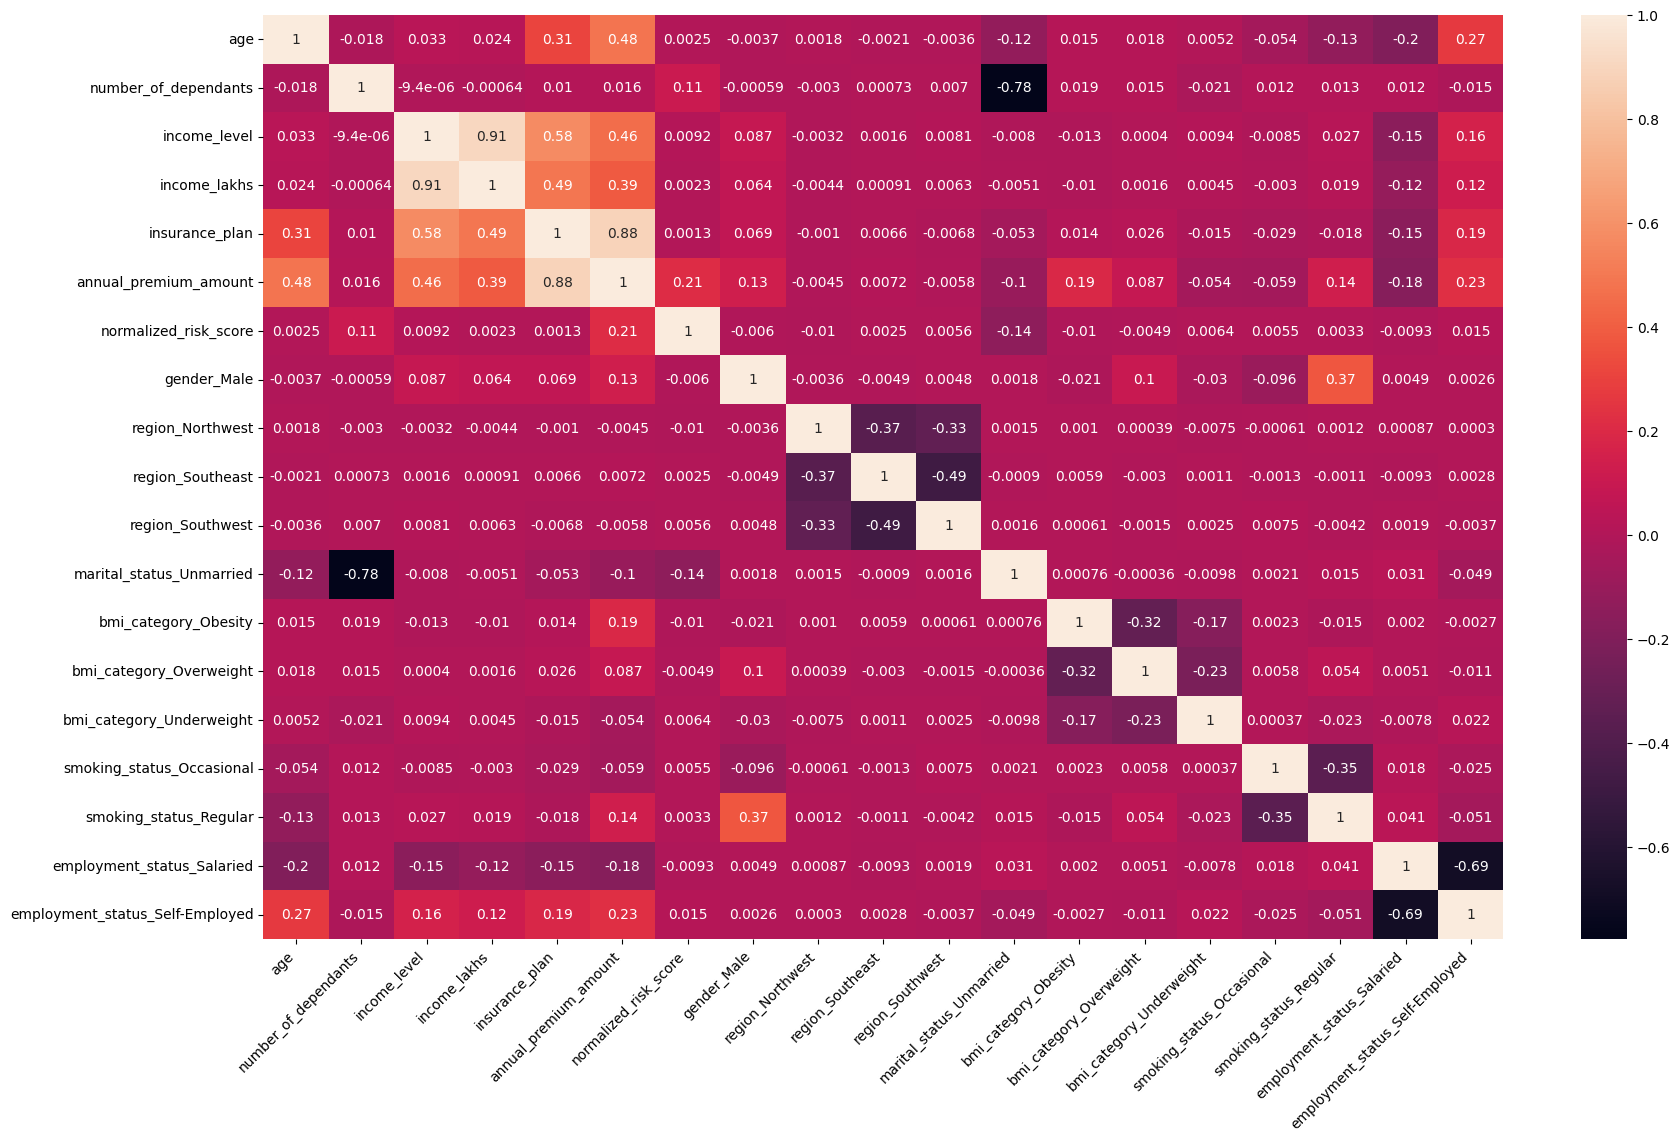

In [48]:
plt.figure(figsize = (20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout
plt.show()

### Separating independent and target variables

In [49]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

In [50]:
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


### Scaling all the values to be between 0 and 1

In [51]:
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.333333,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [53]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Calculating VIF for independent variables

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [55]:
calculate_vif(X)

,column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,normalized_risk_score,3.810619
6,gender_Male,2.599098
7,region_Northwest,2.123965
8,region_Southeast,2.980842
9,region_Southwest,2.710097


In [56]:
X_reduced = X.drop('income_level', axis = 1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [57]:
calculate_vif(X_reduced)

,column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalized_risk_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


### Model Training

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print('y_test:', y_test.shape)

X_train: (20875, 17)
X_test: (8947, 17)
y_train: (20875,)
y_test: (8947,)


In [59]:
model_lr = LinearRegression()

In [60]:
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)

print(f"Train Score: {train_score}, Test Score: {test_score}")

Train Score: 0.9534163989489616, Test Score: 0.9538448451629948


In [61]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)

print("Linear Regression ==> MSE:", mse_lr, "RMSE:", rmse_lr)

Linear Regression ==> MSE: 2183844.3603124553 RMSE: 1477.783597253825


### Checking how the weights of each column contribute to the final annual premium amount

In [62]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
19713,0.652174,0.0,0.262626,1.0,0.428571,0,0,0,1,1,0,0,0,0,0,0,1


In [63]:
model_lr.intercept_

np.float64(5935.981289344585)

In [64]:
model_lr.coef_

array([ 7016.23932829, -1311.76470171,  -708.19336921, 14835.98820801,
        6053.6241234 ,    37.55826883,   -55.25087215,   -19.62254288,
         -22.28967559,  -700.32019985,  3926.8127061 ,  1979.45604663,
         612.86623617,   837.3951011 ,  2800.66184334,   -45.49136706,
         243.07842087])

In [65]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index = X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
number_of_dependants,-1311.764702
income_lakhs,-708.193369
marital_status_Unmarried,-700.320200
region_Northwest,-55.250872
employment_status_Salaried,-45.491367
region_Southwest,-22.289676
region_Southeast,-19.622543
gender_Male,37.558269
employment_status_Self-Employed,243.078421
bmi_category_Underweight,612.866236


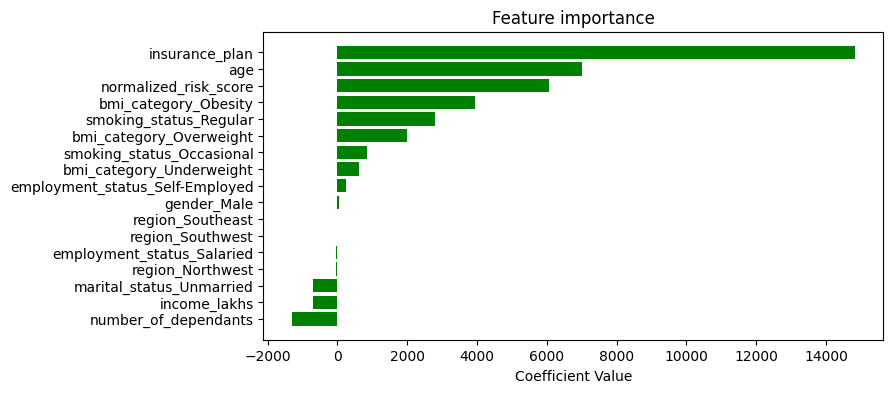

In [66]:
plt.figure(figsize=(8,4))
plt.barh(coef_df.index,coef_df['Coefficients'], color= 'green')
plt.title('Feature importance')
plt.xlabel('Coefficient Value')
plt.show()

### Attempts to improve the model accuracy

In [67]:
model_rg = Ridge(alpha=10)
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)

print(f"Train Score: {train_score}, Test Score: {test_score}")

Train Score: 0.9534000354275609, Test Score: 0.9538387998701963


In [68]:
from xgboost import XGBRegressor

In [69]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)

print(f"Train Score: ({train_score}), Test Score: ({test_score})")

Train Score: (0.9986370801925659), Test Score: (0.9979538321495056)


In [70]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE:", mse_xgb, "RMSE:", rmse_xgb)

XGBoost Regression ==> MSE: 96814.2109375 RMSE: 311.14982072548264


In [71]:
param_grid = {
    'n_estimators' : [20, 40, 50],
    'learning_rate' : [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter = 10, cv = 3, scoring = 'r2', random_state=4)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9977717598279318)

In [72]:
random_search.best_params_

{'n_estimators': 40, 'max_depth': 4, 'learning_rate': 0.2}

In [73]:
random_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=40,
             n_jobs=None, num_parallel_tree=None, ...)

In [74]:
best_model = random_search.best_estimator_

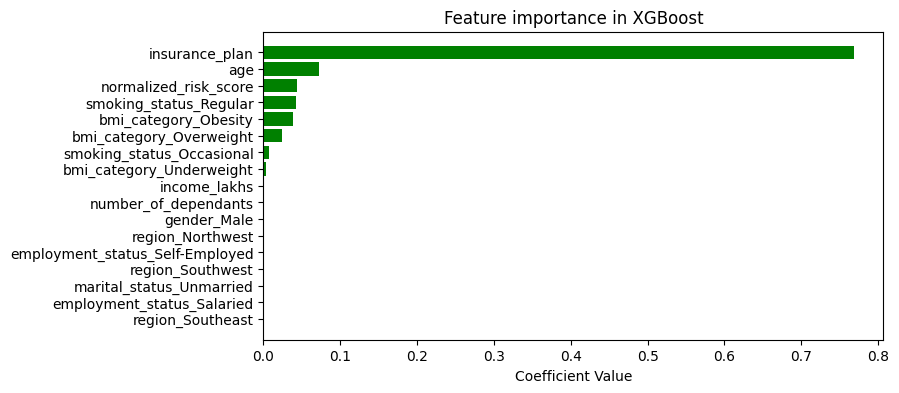

In [75]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, index = X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8,4))
plt.barh(coef_df.index,coef_df['Coefficients'], color= 'green')
plt.title('Feature importance in XGBoost')
plt.xlabel('Coefficient Value')
plt.show()

### Error Analysis

In [76]:
y_pred = best_model.predict(X_test)

residuals = y_pred-y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct':residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26641.001953,-253.998047,-0.944406
14750,22734,22956.232422,222.232422,0.977533
19932,21198,21504.177734,306.177734,1.444371
29643,9100,9271.687500,171.687500,1.886676
17076,26434,26641.001953,207.001953,0.783090


<Axes: xlabel='diff_pct', ylabel='Count'>

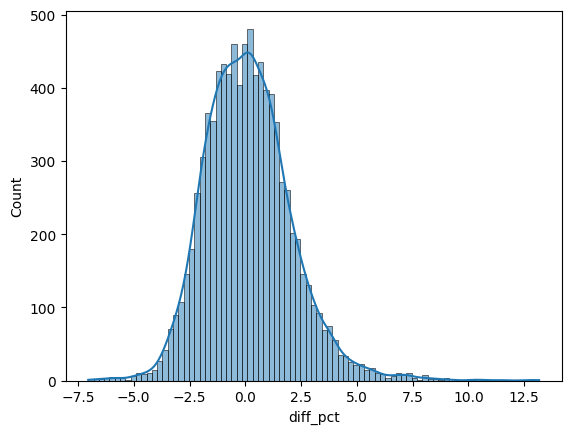

In [77]:
sns.histplot(results_df['diff_pct'], kde=True)

In [79]:
extreme_error_thresold = 10
extreme_results_df = results_df[np.abs((results_df.diff_pct))>extreme_error_thresold]
extreme_results_df.shape

(9, 4)

In [80]:
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

0.10059237733318431

In [81]:
# approx 30% predictions have absolute error of more than 10%

In [82]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending = False)

,actual,predicted,diff,diff_pct


In [84]:
#The index in extreme_results_df is same as the index in X_test. So figuring out the features of these high error predictions

extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
7547,0.347826,0.2,0.080808,0.0,0.0,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0
12189,0.043478,0.6,0.060606,0.0,0.0,1,0,0,1,0,0,0,0,0,0,1,0
8216,0.152174,0.4,0.010101,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0
21455,0.239130,0.2,0.080808,0.0,0.0,1,1,0,0,1,0,0,0,0,0,0,0


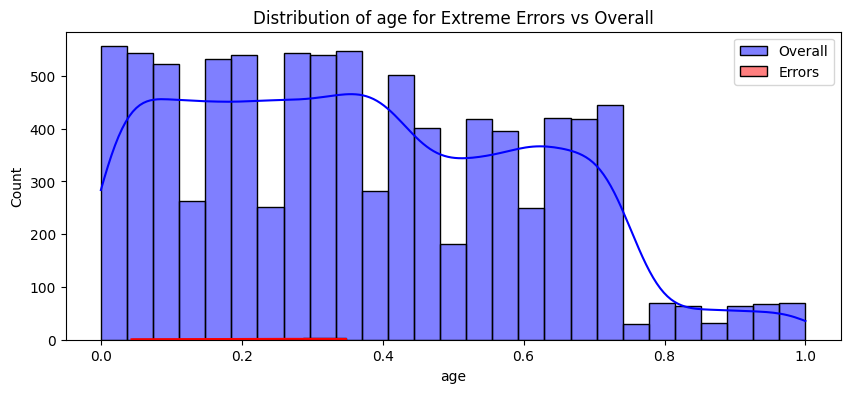

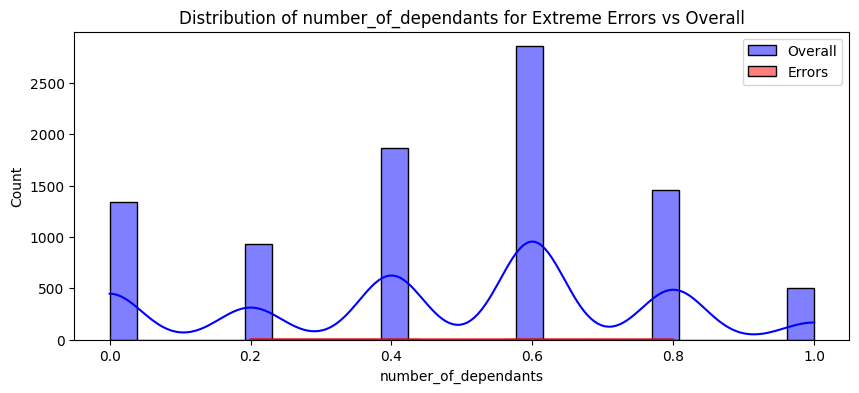

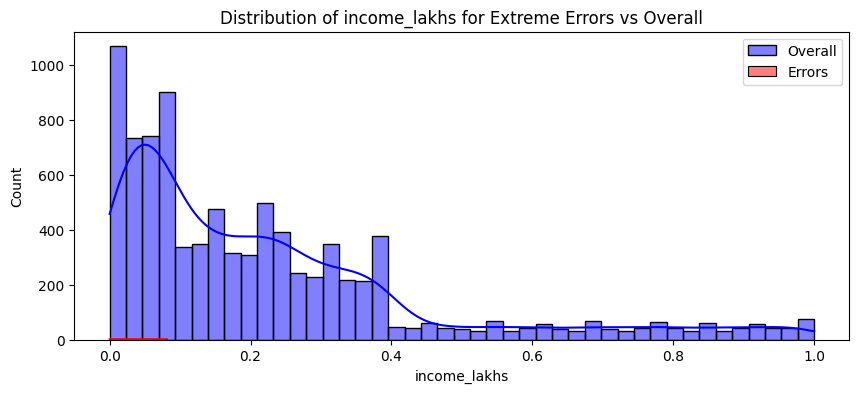

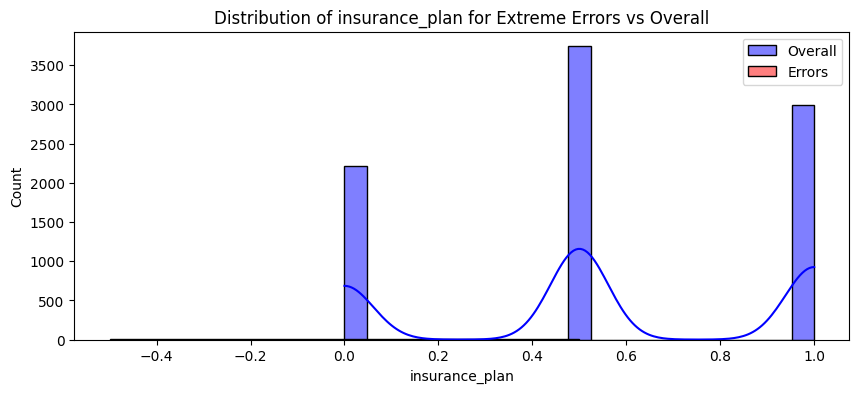

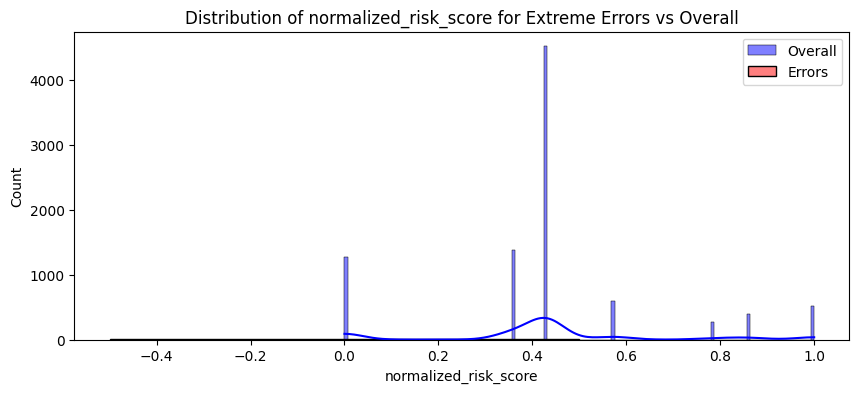

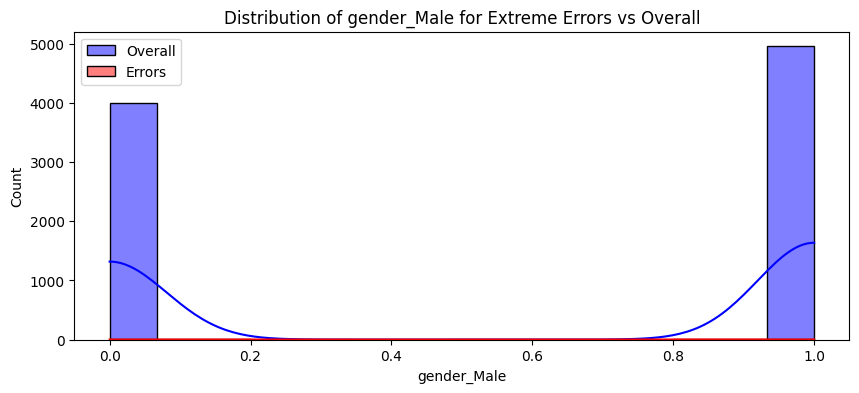

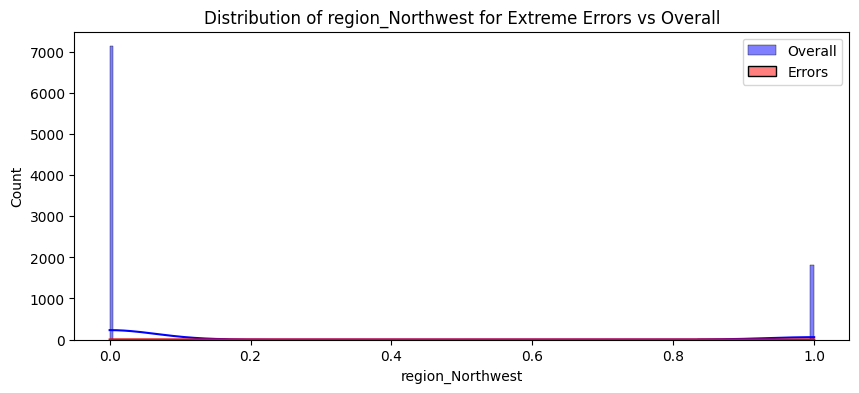

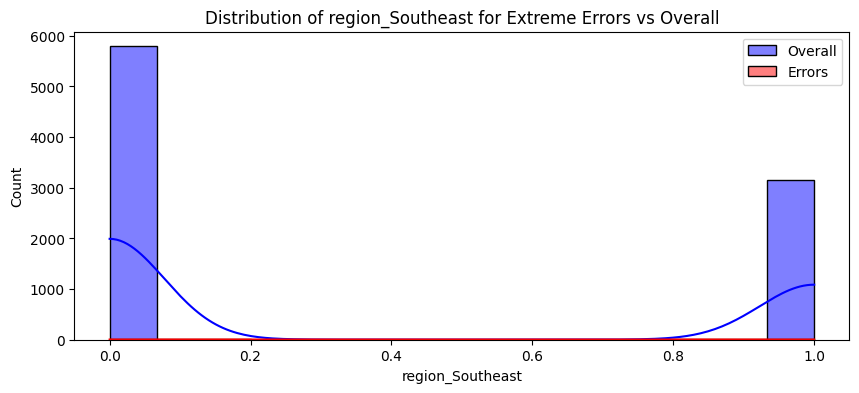

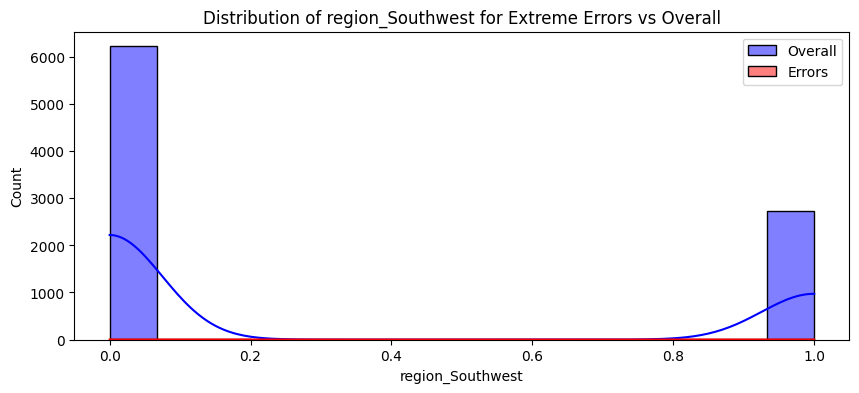

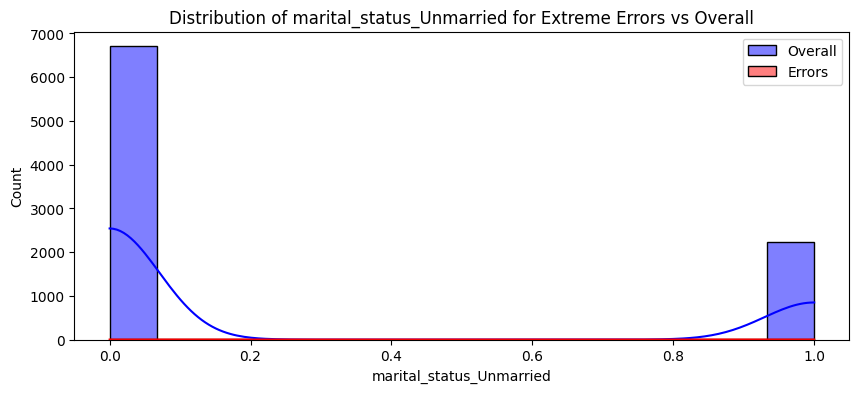

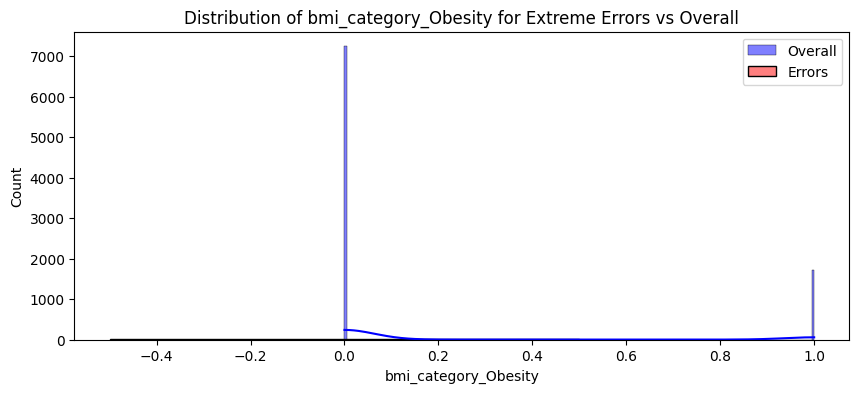

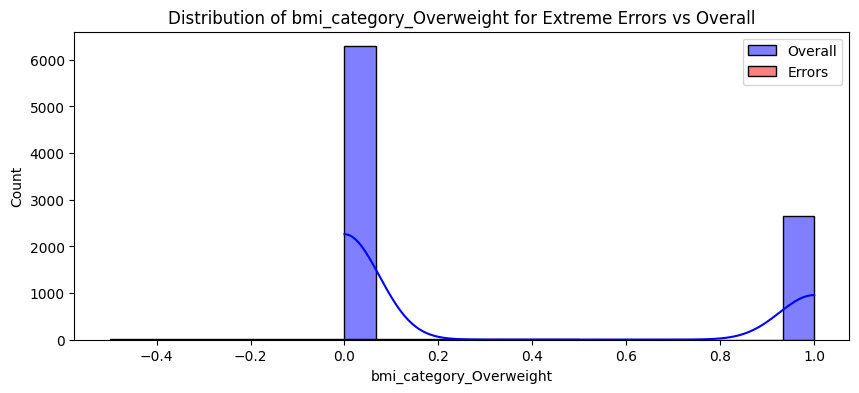

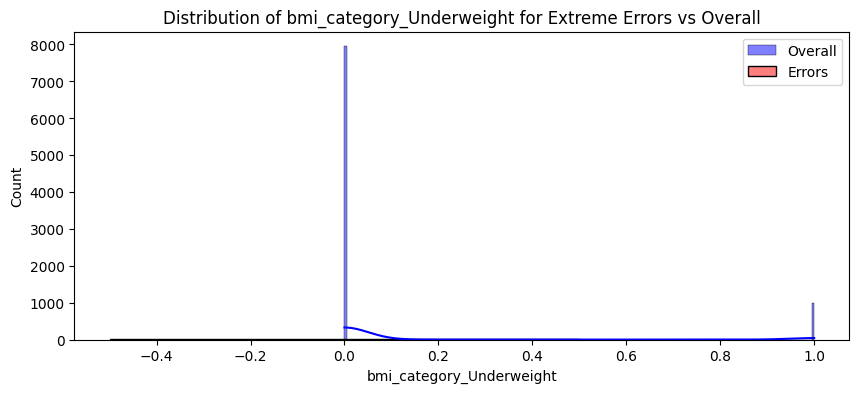

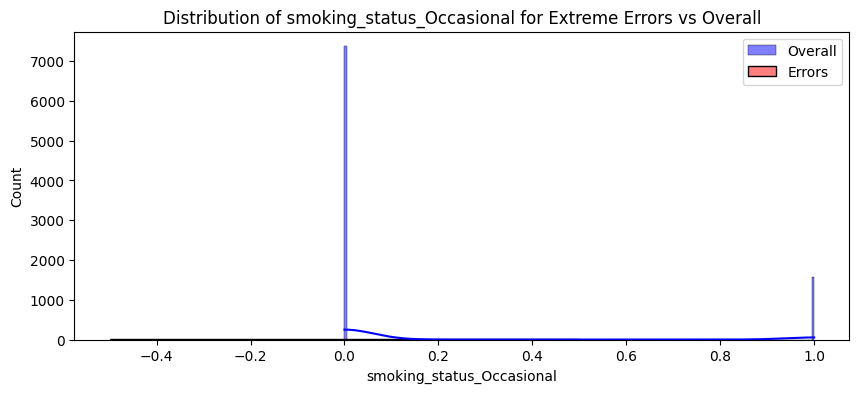

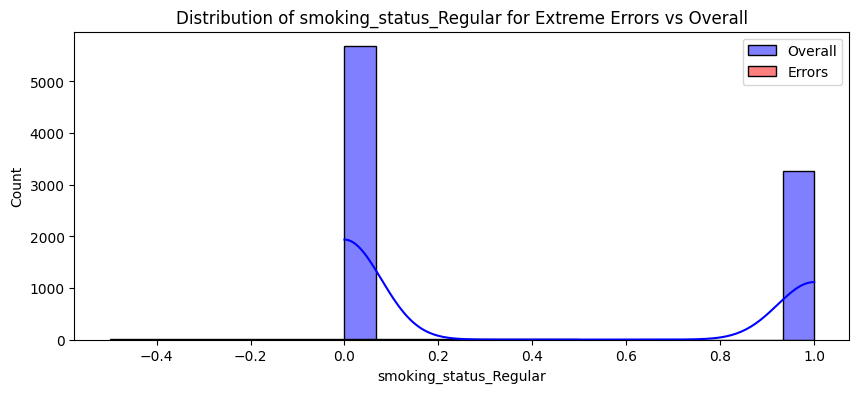

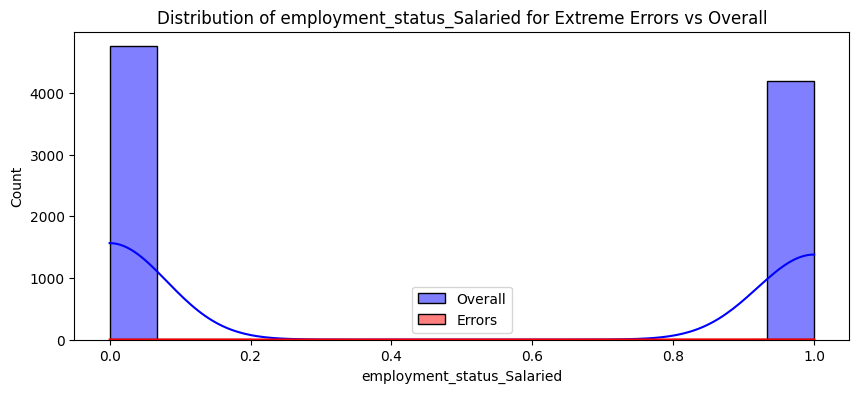

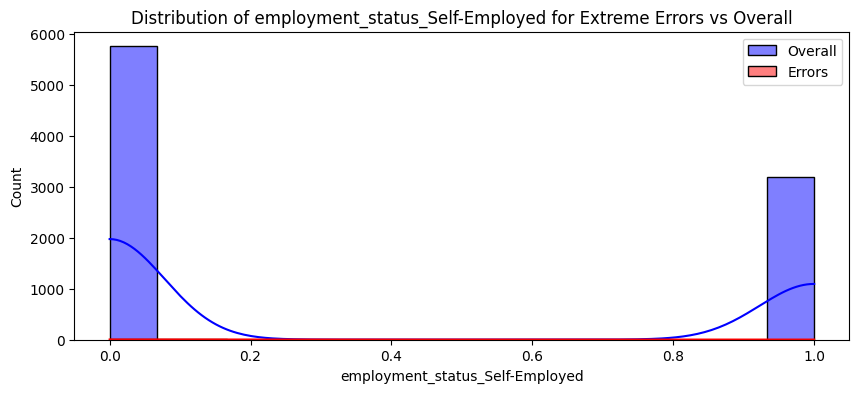

In [85]:
for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    sns.histplot(extreme_errors_df[feature], color='red', label='Errors', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

<Axes: xlabel='age', ylabel='Count'>

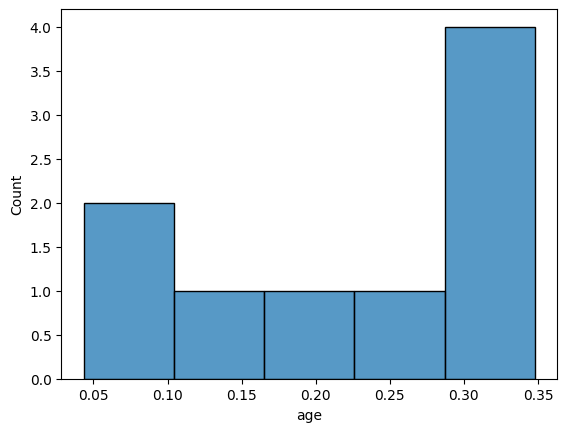

In [87]:
sns.histplot(extreme_errors_df.age)

### Reversing the scaling done previously

In [88]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [89]:
extreme_errors_df['income_level'] = -1

In [90]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed[cols_to_scale].head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,42.0,1.0,-2.0,9.0,1.0
1,28.0,3.0,-2.0,3.0,1.0
2,28.0,3.0,-2.0,7.0,1.0
3,33.0,2.0,-2.0,2.0,1.0
4,37.0,1.0,-2.0,9.0,1.0


<Axes: xlabel='age', ylabel='Count'>

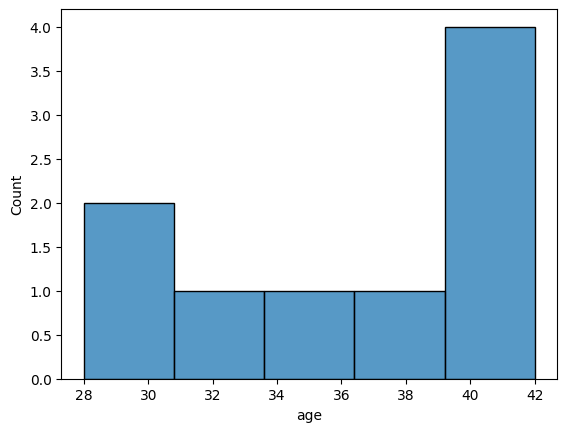

In [91]:
sns.histplot(df_reversed['age'])

In [92]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,9.000000,9.000000,9.0,9.000000,9.0
mean,35.777778,2.111111,-2.0,5.333333,1.0
std,5.309844,1.166667,0.0,3.201562,0.0
min,28.000000,1.000000,-2.0,1.000000,1.0
25%,33.000000,1.000000,-2.0,3.000000,1.0
50%,37.000000,2.000000,-2.0,4.000000,1.0
75%,40.000000,3.000000,-2.0,9.000000,1.0
max,42.000000,4.000000,-2.0,9.000000,1.0


In [93]:
df_reversed['age'].quantile(0.98)

np.float64(41.68)